somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1813 ip_diffim
#setup -k -r .
setup -t 1813 -r .
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [ ]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

In [40]:
import lmfit

def fitDipole(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0.0, flux=3000., noise=1., verbose=False, plot=False):

#     psfWidth = 2.0
#     w, h = 100, 100
#     xc, yc = 50., 50.
#     amplitude = 2.2

# Note this stuff can be moved out of the function for speed
    y, x = np.mgrid[:w, :h]
    x = x.ravel()
    y = y.ravel()
    in_x = [x, y]

    ## Note right now we are only fitting one flux value and the 4 positions, not
    ##   anything related to the shape of the PSF!
    def dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg): #, sig1, sig2):
        """
        Dipole based on 2-d double-gaussian: 
        dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg) #, sig1, sig2)
        """
        try:
            ## Wow - this is about 3x slower than the below (pure python)...
            generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)
 
            zout = np.array([generator(x[0][i] - xcenPos, x[1][i] - ycenPos) for i in xrange(len(x[0]))])
            zmax = np.sum(zout)
            zout -= np.array([generator(x[0][i] - xcenNeg, x[1][i] - ycenNeg) for i in xrange(len(x[0]))])
            zout *= flux / zmax
        except NameError:   ## don't have stack installed, use a custom double gaussian2d generator. 
            def generator(x, y, xc, yc, sigma_x=1., sigma_y=1., theta=0., offset=0.):
                a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
                b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
                c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
                xxc, yyc = x-xc, y-yc
                return offset + np.exp( - (a*(xxc**2) + 2*b*xxc*yyc + c*(yyc**2)))

            #print xcenPos, xcenNeg, ycenPos, ycenNeg
            tmp1 = generator(x[0], x[1], xcenPos, ycenPos, psfWidth, psfWidth)
            tmp1sum = tmp1.sum()
            tmp2 = generator(x[0], x[1], xcenPos, ycenPos, psfWidth*1.75, psfWidth*1.75)
            tmp2sum = tmp2.sum()
            zout = tmp1 * (flux/tmp1sum*0.9)
            zout += tmp2 * (flux/tmp2sum*0.1) 
            tmp1 = generator(x[0], x[1], xcenNeg, ycenNeg, psfWidth, psfWidth)
            tmp2 = generator(x[0], x[1], xcenNeg, ycenNeg, psfWidth*1.75, psfWidth*1.75)
            zout -= tmp1 * (flux/tmp1sum*0.9)
            zout -= tmp2 * (flux/tmp2sum*0.1)
            
        return zout

    #z = np.array([generator(in_x[0][i] - xc, in_x[1][i] - yc) for i in np.arange(len(in_x[0]))])
    #z *= ht / z.max()
    rotAngRad = rotAngle / 180. * np.pi
    sep = separation / 2.
    z = dipoleFunc(in_x, flux, xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad), 
                   xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)) #, psfWidth, psfWidth*1.75)
    ## TBD: accurate (poisson) noise proportional to pixel intensity
    z += np.random.normal(0., noise, x.shape) #* (0.1 + np.sqrt(np.abs(z)))
    
    gmod = lmfit.Model(dipoleFunc, verbose=verbose)
    maxPos = np.array(np.unravel_index(np.argmax(z), (w,h)))
    minPos = np.array(np.unravel_index(np.argmin(z), (w,h)))
    startingFlux = np.abs(z).sum() / 2. #z.ptp() / 2.  ## ptp = max-min
    
    ## For close/faint dipoles the starting locs (min/max) might be way off, let's help them a bit:
    if minPos[0] < xc-sep*2.: minPos[0] = xc-sep*2.
    elif minPos[0] > xc+sep*2.: minPos[0] = xc+sep*2.
    if minPos[1] < yc-sep*2.: minPos[1] = yc-sep*2.
    elif minPos[1] > yc+sep*2.: minPos[1] = yc+sep*2.
    if maxPos[0] < xc-sep*2.: maxPos[0] = xc-sep*2.
    elif maxPos[0] > xc+sep*2.: maxPos[0] = xc+sep*2.
    if maxPos[1] < yc-sep*2.: maxPos[1] = yc-sep*2.
    elif maxPos[1] > yc+sep*2.: maxPos[1] = yc+sep*2.

    ## parameter hints/constraints: https://lmfit.github.io/lmfit-py/model.html#model-param-hints-section
    gmod.set_param_hint('xcenPos', value=maxPos[1], min=maxPos[1]-psfWidth*2., max=maxPos[1]+psfWidth*2.)
    gmod.set_param_hint('ycenPos', value=maxPos[0], min=maxPos[0]-psfWidth*2., max=maxPos[0]+psfWidth*2.)
    gmod.set_param_hint('xcenNeg', value=minPos[1], min=minPos[1]-psfWidth*2., max=minPos[1]+psfWidth*2.)
    gmod.set_param_hint('ycenNeg', value=minPos[0], min=minPos[0]-psfWidth*2., max=minPos[0]+psfWidth*2.)
    gmod.set_param_hint('flux', value=startingFlux, min=0.1, max=99999.)  ## TBD: higher flux limit? 
    
    result = gmod.fit(z, x=in_x, flux=startingFlux, xcenPos=maxPos[1], ycenPos=maxPos[0], 
                      xcenNeg=minPos[1], ycenNeg=minPos[0], verbose=verbose) #, sig1=1., sig2=2.)
    
    if verbose: 
        print(result.fit_report(show_correl=False))
        ## This is how to get confidence intervals out, see here: https://lmfit.github.io/lmfit-py/confidence.html and 
        ##    here: http://cars9.uchicago.edu/software/python/lmfit/model.html
        ## Note this calc takes a long time (longer than the fit!)
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    if plot:
        zptp = z.ptp() / 2.
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        plt.imshow(z.reshape(w, h), origin='lower', interpolation='none', cmap='gray' )#, vmin=-zptp, vmax=zptp)
        plt.title("Data")
        plt.subplot(1, 3, 2)
        plt.imshow(result.best_fit.reshape(w, h), origin='lower', interpolation='none', cmap='gray')#, vmin=-zptp, vmax=zptp)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(z.reshape(w, h) - result.best_fit.reshape(w, h), origin='lower', cmap='gray', interpolation='none')
        plt.title("Residual")
#        plt.subplot(1, 4, 4)
#        plt.imshow(z.reshape(w, h) - result.init_fit.reshape(w, h), origin='lower', cmap='gray', interpolation='none')
#        plt.title("Residual (initial)")
        
    return x, y, z, result

def getDipoleFitResults(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0., flux=100., 
                        noise=1., verbose=False, plot=False):
    x, y, z, result = fitDipole(w=w, h=h, xc=xc, yc=yc, psfWidth=psfWidth, separation=separation, rotAngle=rotAngle,
                                flux=flux, noise=noise, verbose=verbose, plot=plot)
    return result #.best_values

 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 47
    # data points      = 10000
    # variables        = 5
    chi-square         = 10061.974
    reduced chi-square = 1.007
[[Variables]]
    xcenPos:   50.7884690 +/- 0.032470 (0.06%) (init= 52)
    ycenPos:   49.4252700 +/- 0.025017 (0.05%) (init= 49)
    xcenNeg:   49.1902906 +/- 0.032470 (0.07%) (init= 48)
    ycenNeg:   50.5919431 +/- 0.025017 (0.05%) (init= 51)
    flux:      3021.69699 +/- 105.3969 (3.49%) (init= 5008.978)

            99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 xcenPos:  -0.10083  -0.06549  -0.03164  50.78847  +0.03034  +0.0617

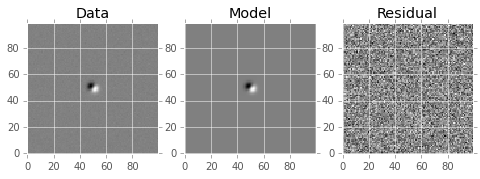

In [15]:
x, y, z, result = fitDipole(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=324., 
                            flux=3000., noise=1., verbose=True, plot=True)

In [16]:
%timeit getDipoleFitResults(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0., \
                              flux=3000., noise=1., verbose=False, plot=False)

result = getDipoleFitResults(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0.,
                              flux=3000., noise=1., verbose=False, plot=False)
results = result.best_values
print results

centroid = ((results['xcenPos']+results['xcenNeg'])/2., (results['ycenPos']+results['ycenNeg'])/2.)
print 'CENTROID:', centroid

dx, dy = results['xcenPos']-results['xcenNeg'], results['ycenPos']-results['ycenNeg']
angle = np.arctan2(dy, dx) / np.pi * 180.
print 'ANGLE:', angle

## Note this (conf interval computation) takes too long. Let's use estimated uncertainties from the model fit
#ci = lmfit.conf_interval(result, result, sigmas=[0.68, 0.95])
#lmfit.printfuncs.report_ci(ci)

# This is how we get out the errors in the parameters from the fit:
#for pname, par in result.params.items():
#    print pname, par.value, par.stderr    

fluxVal, fluxErr = result.params['flux'].value, result.params['flux'].stderr
#signalToNoise = np.sqrt((fluxVal/fluxErr)**2 + (fluxVal/fluxErr)**2) ## This is from DipoleAnalysis code
signalToNoise = np.sqrt(2.) * fluxVal/fluxErr
print 'S/N:', signalToNoise

10 loops, best of 3: 35.2 ms per loop
{'flux': 2974.324125466213, 'xcenPos': 51.016765485186575, 'ycenPos': 50.009816841742833, 'ycenNeg': 50.015745751111382, 'xcenNeg': 48.98908139713572}
CENTROID: (50.002923441161144, 50.012781296427107)
ANGLE: -0.167531282525
S/N: 42.7858512173


In [17]:
varNames = getDipoleFitResults.__code__.co_varnames[:getDipoleFitResults.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

#orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)

inputs = [varTuple(w=100, h=100, xc=50., yc=50., psfWidth=2.0, separation=sep, rotAngle=0., 
                    flux=3000., noise=1., verbose=False, plot=False) for i in xrange(10) for sep in separations]

def processInput(i):
    #print i.separation #, i.rotAngle
    output = getDipoleFitResults(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                                 rotAngle=i.rotAngle, flux=i.flux, noise=i.noise, verbose=False, plot=False)
    output = output.best_values
    output['separation'] = i.separation
    output['inputCentroidPos'] = (i.xc+i.separation/2., i.yc+i.separation/2.)
    output['inputCentroidNeg'] = (i.xc-i.separation/2., i.yc-i.separation/2.)
    return output

num_cores = multiprocessing.cpu_count() / 2
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

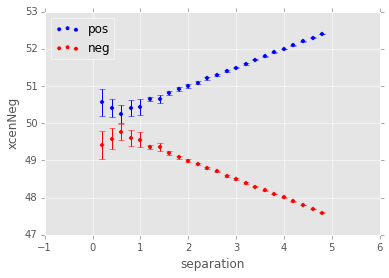

In [18]:
df = pd.DataFrame(results)
#sizeme(df)

tmp_df = df.groupby('separation').mean()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').std() * 1.
ax = tmp_df.plot(x='separation', y='xcenPos', kind='scatter', yerr=tmp_df2['xcenPos'], color='blue', label='pos')
tmp_df.plot(x='separation', y='xcenNeg', kind='scatter', yerr=tmp_df2['xcenNeg'], color='red', label='neg', ax=ax)

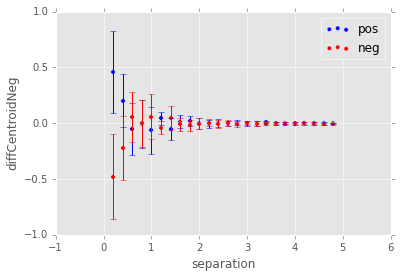

In [19]:
df['diffCentroidPos'] = df.xcenPos.values - np.array([i[0] for i in df.inputCentroidPos])
df['diffCentroidNeg'] = df.xcenNeg.values - np.array([i[0] for i in df.inputCentroidNeg])

tmp_df = df.groupby('separation').mean()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').std() * 1.
ax = tmp_df.plot(x='separation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='separation', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], color='red', label='neg', ax=ax)

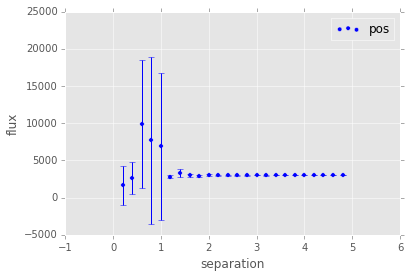

In [20]:
tmp_df = df.groupby('separation').mean()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').std() * 1.
ax = tmp_df.plot(x='separation', y='flux', kind='scatter', yerr=tmp_df2['flux'], color='blue', label='pos')
#tmp_df.plot(x='separation', y='flux', kind='scatter', yerr=tmp_df2['flux'], color='red', label='neg', ax=ax)

Try it again, this time setting different orientations as well. Next time we'll also test it as a function of scaling (source flux).

### Different orientations

In [21]:
varNames = getDipoleFitResults.__code__.co_varnames[:getDipoleFitResults.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)

inputs = [varTuple(w=100, h=100, xc=50., yc=50., psfWidth=2.0, separation=sep, rotAngle=rot, 
                    flux=3000., noise=1., verbose=False, plot=False) for rot in orientations for sep in separations]

def processInput(i):
    #print i.separation, i.rotAngle
    output = getDipoleFitResults(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                                 rotAngle=i.rotAngle, flux=i.flux, noise=i.noise, verbose=False, plot=False)
    output = output.best_values
    output['separation'] = i.separation
    rotAngRad = i.rotAngle / 180. * np.pi
    sep = i.separation / 2.
    output['inputCentroidPos'] = (i.xc+sep*np.cos(rotAngRad), i.yc+sep*np.sin(rotAngRad))
    output['inputCentroidNeg'] = (i.xc-sep*np.cos(rotAngRad), i.yc-sep*np.sin(rotAngRad))
    output['rotAngle'] = i.rotAngle
    return output

    z = dipoleFunc(in_x, flux, xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad), 
                   xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)) #, psfWidth, psfWidth*1.75)
 

num_cores = multiprocessing.cpu_count() / 2
results2 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

In [22]:
df = pd.DataFrame(results2)
print df.shape
df['rmsCentroidPos'] = np.sqrt((np.array([i[0] for i in df.inputCentroidPos]) - df.xcenPos.values)**2. + \
                               (np.array([i[1] for i in df.inputCentroidPos]) - df.ycenPos.values)**2.)
df['rmsCentroidNeg'] = np.sqrt((np.array([i[0] for i in df.inputCentroidNeg]) - df.xcenNeg.values)**2. + \
                               (np.array([i[1] for i in df.inputCentroidNeg]) - df.ycenNeg.values)**2.)
sizeme(df[df.rmsCentroidPos>1].tail())

(240, 9)


,flux,inputCentroidNeg,inputCentroidPos,rotAngle,separation,xcenNeg,xcenPos,ycenNeg,ycenPos,rmsCentroidPos,rmsCentroidNeg


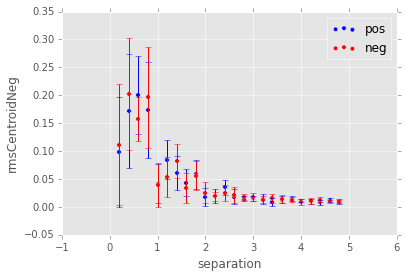

In [23]:
tmp_df = df.groupby('separation').median()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').mad() * 1.
ax = tmp_df.plot(x='separation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='separation', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

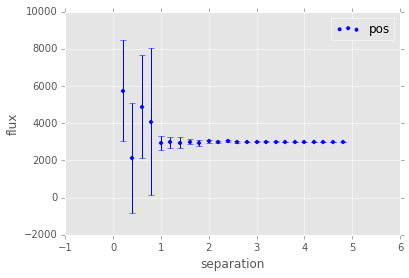

In [24]:
tmp_df = df.groupby('separation').median()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').mad() * 1.
ax = tmp_df.plot(x='separation', y='flux', kind='scatter', yerr=tmp_df2['flux'], color='blue', label='pos')

## Different dipole fluxes (signal-to-noise)

In [41]:
varNames = getDipoleFitResults.__code__.co_varnames[:getDipoleFitResults.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)
fluxes = np.arange(250., 6000., 250.)

inputs = [varTuple(w=100, h=100, xc=50., yc=50., psfWidth=2.0, separation=sep, rotAngle=rot, 
                    flux=flux, noise=1., verbose=False, plot=False) 
                      for flux in fluxes for rot in orientations for sep in separations]
print len(inputs)

def processInput(i):
    #print i.flux #i.separation, i.rotAngle
    output = getDipoleFitResults(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                                 rotAngle=i.rotAngle, flux=i.flux, noise=i.noise, verbose=False, plot=False)
    output = output.best_values
    output['separation'] = i.separation
    rotAngRad = i.rotAngle / 180. * np.pi
    sep = i.separation / 2.
    output['inputCentroidPos'] = (i.xc+sep*np.cos(rotAngRad), i.yc+sep*np.sin(rotAngRad))
    output['inputCentroidNeg'] = (i.xc-sep*np.cos(rotAngRad), i.yc-sep*np.sin(rotAngRad))
    output['inputFlux'] = i.flux
    output['rotAngle'] = i.rotAngle
    return output

    z = dipoleFunc(in_x, flux, xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad), 
                   xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)) #, psfWidth, psfWidth*1.75)
 
num_cores = multiprocessing.cpu_count() / 2
results3 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

5520


In [47]:
df = pd.DataFrame(results3)
df['rmsCentroidPos'] = np.sqrt((np.array([i[0] for i in df.inputCentroidPos]) - df.xcenPos.values)**2. + \
                               (np.array([i[1] for i in df.inputCentroidPos]) - df.ycenPos.values)**2.)
df['rmsCentroidNeg'] = np.sqrt((np.array([i[0] for i in df.inputCentroidNeg]) - df.xcenNeg.values)**2. + \
                               (np.array([i[1] for i in df.inputCentroidNeg]) - df.ycenNeg.values)**2.)

## Filter out bad values where the fit was obviously bad -- TBD - throw an error upstream instead.
print df.shape, df[df.flux < 90000.].shape
df = df[df.flux < 90000.]
#sizeme(df.head())

(5520, 12) (5498, 12)


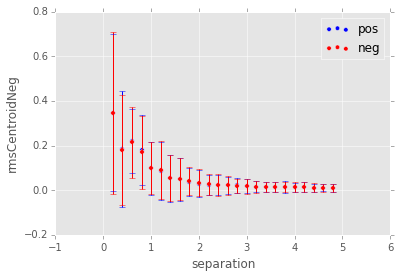

In [48]:
tmp_df = df.groupby('separation').median()
tmp_df['separation'] = tmp_df.index.values
tmp_df2 = df.groupby('separation').mad() * 1.
ax = tmp_df.plot(x='separation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='separation', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

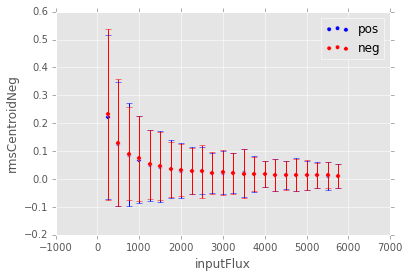

In [49]:
tmp_df = df.groupby('inputFlux').median()
tmp_df['inputFlux'] = tmp_df.index.values
tmp_df2 = df.groupby('inputFlux').mad() * 1.
ax = tmp_df.plot(x='inputFlux', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='inputFlux', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

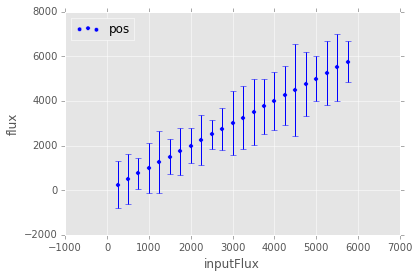

In [50]:
tmp_df = df.groupby('inputFlux').median()
tmp_df['inputFlux'] = tmp_df.index.values
tmp_df2 = df.groupby('inputFlux').mad() * 1.
ax = tmp_df.plot(x='inputFlux', y='flux', kind='scatter', color='blue', label='pos', yerr=tmp_df2['flux'])